# Wildfire Detection Evaluation - Nemotron VLM

This notebook evaluates the Nemotron vision-language model on the wildfire test dataset.

**Workflow:**
1. Start a local HTTP server to serve images
2. Load images from local directory: `/raid/aasthaj/wildfire-nemo/data/3/the_wildfire_dataset_2n_version/test/`
3. Send HTTP URLs (accessible from Docker container) to the VLM API endpoint
4. Collect predictions and ground truth labels
5. Compute classification metrics (TP, FP, FN, TN, Precision, Recall, F1, Accuracy)
6. Save results to CSV

**Note:** The NIM API requires HTTP/HTTPS URLs. We serve images via HTTP from the host machine's IP address so the Docker container can access them.


## 1. Install Dependencies

Install required packages (run this once).


In [28]:
%pip install requests numpy pandas tqdm matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


## 2. Setup and Imports


In [29]:
import os
import csv
import json
import threading
import time
import socket
from pathlib import Path
from http.server import HTTPServer, SimpleHTTPRequestHandler
from urllib.parse import quote

import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Imports complete")


✓ Imports complete


## 3. Configuration

Set the API endpoint, model name, and paths to your test data.


In [41]:
# API Configuration
API_URL = "http://0.0.0.0:8000/v1/chat/completions"
MODEL_NAME = "nvidia/nemotron-nano-12b-v2-vl"
REQUEST_TIMEOUT = 60.0  # seconds

# Data paths
DATA_ROOT = Path("/raid/aasthaj/wildfire-nemo/data/3/the_wildfire_dataset_2n_version")
TEST_ROOT = DATA_ROOT / "test"
FIRE_DIR = TEST_ROOT / "fire"
NOFIRE_DIR = TEST_ROOT / "nofire"

# Testing Configuration
# Set to None to use all images, or specify a number for quick testing
# Examples: SUBSET_SIZE = 10 (5 fire + 5 nofire), SUBSET_SIZE = 50 (25 fire + 25 nofire)
SUBSET_SIZE = None  # Change to a number like 20 for quick testing

# HTTP Server Configuration
HTTP_SERVER_PORT = 8888

def get_host_ip():
    """Get the host machine's IP address."""
    try:
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        s.connect(("8.8.8.8", 80))
        ip = s.getsockname()[0]
        s.close()
        return ip
    except Exception:
        return "10.185.124.93"  # Fallback to known IP

HTTP_SERVER_HOST = get_host_ip()

# Output path
OUTPUT_CSV = Path("/raid/aasthaj/wildfire-nemo/outputs/nemotron_wildfire_test_results.csv")
OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)

print(f"API URL: {API_URL}")
print(f"Model: {MODEL_NAME}")
print(f"Test root: {TEST_ROOT}")
print(f"Testing mode: {'SUBSET (' + str(SUBSET_SIZE) + ' images)' if SUBSET_SIZE else 'FULL DATASET'}")
print(f"HTTP Server will use: http://{HTTP_SERVER_HOST}:{HTTP_SERVER_PORT}")
print(f"Output CSV: {OUTPUT_CSV}")


API URL: http://0.0.0.0:8000/v1/chat/completions
Model: nvidia/nemotron-nano-12b-v2-vl
Test root: /raid/aasthaj/wildfire-nemo/data/3/the_wildfire_dataset_2n_version/test
Testing mode: FULL DATASET
HTTP Server will use: http://10.185.124.93:8888
Output CSV: /raid/aasthaj/wildfire-nemo/outputs/nemotron_wildfire_test_results.csv


## 4. Start HTTP Server

Start a local HTTP server to serve images via HTTP URLs.


In [42]:
def find_available_port(start_port, max_attempts=10):
    """Find an available port starting from start_port."""
    for port in range(start_port, start_port + max_attempts):
        try:
            with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
                s.bind(('', port))
                return port
        except OSError:
            continue
    raise RuntimeError(f"Could not find available port in range {start_port}-{start_port+max_attempts}")

def start_http_server(directory, port):
    """Start HTTP server in the given directory."""
    
    # Create a custom handler that serves from the specified directory
    class QuietHTTPRequestHandler(SimpleHTTPRequestHandler):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, directory=directory, **kwargs)
        
        def log_message(self, format, *args):
            pass  # Suppress logging
    
    server = HTTPServer(('0.0.0.0', port), QuietHTTPRequestHandler)
    thread = threading.Thread(target=server.serve_forever, daemon=True)
    thread.start()
    return server

# Find available port and start server
HTTP_SERVER_PORT = find_available_port(HTTP_SERVER_PORT)
SERVER_ROOT = DATA_ROOT
http_server = start_http_server(str(SERVER_ROOT), HTTP_SERVER_PORT)
time.sleep(1)  # Give server time to start

print(f"✓ HTTP server started on port {HTTP_SERVER_PORT}")
print(f"  Serving from: {SERVER_ROOT}")
print(f"  Example URL: http://{HTTP_SERVER_HOST}:{HTTP_SERVER_PORT}/test/fire/")


✓ HTTP server started on port 8891
  Serving from: /raid/aasthaj/wildfire-nemo/data/3/the_wildfire_dataset_2n_version
  Example URL: http://10.185.124.93:8891/test/fire/


## 5. Helper Functions


In [43]:
def image_path_to_url(image_path: Path, base_dir: Path, host: str, port: int) -> str:
    """Convert a local image path to an HTTP URL."""
    rel_path = image_path.relative_to(base_dir)
    encoded_path = "/".join(quote(part) for part in rel_path.parts)
    return f"http://{host}:{port}/{encoded_path}"


def build_payload(model: str, image_url: str) -> dict:
    """
    Build the JSON payload per NVIDIA NIM documentation.
    """
    system_prompt = (
        "You are a wildfire detection expert. Analyze the image and provide a classification with reasoning.\n\n"
        "START your response with one of these labels on the first line:\n"
        "FIRE\n"
        "NO_FIRE\n\n"
        "Then on the following lines, explain your reasoning.\n\n"
        "Classification criteria:\n"
        "- Use FIRE if you see: active flames, burning, wildfire smoke (dense plumes from vegetation/forest), or signs of active fire spread\n"
        "- Use NO_FIRE for: clear landscapes, normal clouds, fog, steam, or images with no fire indicators\n\n"
        "Example format:\n"
        "FIRE\n"
        "The image shows dense smoke rising from forest vegetation, indicating an active wildfire...\n\n"
        "Remember: START with FIRE or NO_FIRE on the first line at all times before explaining your reasoning."
    )

    user_text = "Classify this image as FIRE or NO_FIRE. Start with the label, then explain your reasoning."

    return {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {"url": image_url},
                    },
                    {
                        "type": "text",
                        "text": user_text,
                    },
                ],
            },
        ],
        "max_tokens": 128,
        "temperature": 0,
    }


def parse_model_response(model_response: str) -> tuple:
    """
    Parse the model's response to extract label and explanation.
    Returns: (label_int, label_str, explanation)
    """
    text = model_response.strip()
    lines = text.split('\n', 1)  # Split at first newline
    
    first_line = lines[0].strip().upper()
    explanation = lines[1].strip() if len(lines) > 1 else ""
    
    # Check first line for label
    if "FIRE" in first_line and "NO_FIRE" not in first_line and "NO FIRE" not in first_line:
        return 1, "fire", explanation
    elif "NO_FIRE" in first_line or "NO FIRE" in first_line or "NOFIRE" in first_line:
        return 0, "no_fire", explanation
    
    # Fallback: check entire response
    lower = text.lower()
    if "fire" in lower and "no fire" not in lower and "no_fire" not in lower:
        return 1, "fire", text
    if "no fire" in lower or "no_fire" in lower or "no wildfire" in lower:
        return 0, "no_fire", text
    
    # Default to no_fire if uncertain
    return 0, "no_fire", text


print("✓ Helper functions defined")


✓ Helper functions defined


## 6. Load Test Images


In [44]:
# Collect fire images
fire_images_all = sorted([p for p in FIRE_DIR.glob("**/*") if p.is_file()])
nofire_images_all = sorted([p for p in NOFIRE_DIR.glob("**/*") if p.is_file()])

print(f"Found {len(fire_images_all)} fire images")
print(f"Found {len(nofire_images_all)} nofire images")
print(f"Total: {len(fire_images_all) + len(nofire_images_all)} images")

# Apply subset if configured
if SUBSET_SIZE is not None:
    subset_per_class = SUBSET_SIZE // 2
    fire_images = fire_images_all[:subset_per_class]
    nofire_images = nofire_images_all[:subset_per_class]
    print(f"\n⚠️  SUBSET MODE: Using {len(fire_images)} fire + {len(nofire_images)} nofire = {len(fire_images) + len(nofire_images)} total images")
else:
    fire_images = fire_images_all
    nofire_images = nofire_images_all
    print(f"\n✓ FULL DATASET: Using all {len(fire_images) + len(nofire_images)} images")

# Show example URL
if fire_images:
    example_url = image_path_to_url(fire_images[0], SERVER_ROOT, HTTP_SERVER_HOST, HTTP_SERVER_PORT)
    print(f"\nExample URL: {example_url}")


Found 159 fire images
Found 251 nofire images
Total: 410 images

✓ FULL DATASET: Using all 410 images

Example URL: http://10.185.124.93:8891/test/fire/19196558588_267f24b847_o.jpg


## 7. Run Evaluation


In [45]:
# Initialize storage for results
results = []
y_true = []
y_pred = []

# Create a requests session for connection pooling
session = requests.Session()


def process_image(image_path: Path, gt_label_str: str, gt_label_int: int):
    """
    Process a single image: create HTTP URL, send to API, parse response.
    """
    # Convert path to HTTP URL
    image_url = image_path_to_url(image_path, SERVER_ROOT, HTTP_SERVER_HOST, HTTP_SERVER_PORT)
    
    # Build payload
    payload = build_payload(MODEL_NAME, image_url)
    
    # Call API
    try:
        resp = session.post(API_URL, json=payload, timeout=REQUEST_TIMEOUT)
        resp.raise_for_status()
        resp_json = resp.json()
        content = resp_json["choices"][0]["message"]["content"]
        model_response = content if isinstance(content, str) else str(content)
    except Exception as e:
        model_response = f"ERROR: {e}"
    
    # Parse response to extract label and explanation
    pred_label_int, pred_label_str, explanation = parse_model_response(model_response)
    
    # Store results
    results.append({
        "image_name": image_path.name,
        "image_path": str(image_path),
        "ground_truth": gt_label_str,
        "parsed_label": pred_label_str,
        "explanation": explanation,
        "full_response": model_response,
    })
    
    y_true.append(gt_label_int)
    y_pred.append(pred_label_int)


# Process fire images
print("Processing fire images...")
for img_path in tqdm(fire_images, desc="Fire images"):
    process_image(img_path, "fire", 1)

# Process nofire images
print("\nProcessing nofire images...")
for img_path in tqdm(nofire_images, desc="Nofire images"):
    process_image(img_path, "nofire", 0)

print("\n✓ Evaluation complete!")


Processing fire images...


Fire images: 100%|██████████| 159/159 [05:22<00:00,  2.03s/it]



Processing nofire images...


Nofire images: 100%|██████████| 251/251 [09:37<00:00,  2.30s/it]


✓ Evaluation complete!


## 8. Save Results to CSV


In [46]:
# Create DataFrame
df_results = pd.DataFrame(results)

# Save to CSV
df_results.to_csv(OUTPUT_CSV, index=False)

print(f"✓ Results saved to: {OUTPUT_CSV}")
print(f"\nFirst few rows:")
df_results.head()


✓ Results saved to: /raid/aasthaj/wildfire-nemo/outputs/nemotron_wildfire_test_results.csv

First few rows:


,image_name,image_path,ground_truth,parsed_label,explanation,full_response
0,19196558588_267f24b847_o.jpg,/raid/aasthaj/wildfire-nemo/data/3/the_wildfir...,fire,no_fire,,NO_FIRE. The image does not depict an actual f...
1,20960888741_8c4be2c1df_o.jpg,/raid/aasthaj/wildfire-nemo/data/3/the_wildfir...,fire,fire,The presence of smoke in the image is a strong...,FIRE\n\nThe presence of smoke in the image is ...
2,26131736898_9e6a8cd68f_o.jpg,/raid/aasthaj/wildfire-nemo/data/3/the_wildfir...,fire,no_fire,The image does not show any signs of fire. The...,NO_FIRE\n\nThe image does not show any signs o...
3,26549039025_b4cce14ec7_o.jpg,/raid/aasthaj/wildfire-nemo/data/3/the_wildfir...,fire,fire,"The presence of smoke in the distance, particu...","FIRE\n\nThe presence of smoke in the distance,..."
4,27002088114_aa5cc7f353_o.jpg,/raid/aasthaj/wildfire-nemo/data/3/the_wildfir...,fire,fire,"The image clearly depicts a fire, as evidenced...","FIRE\n\nThe image clearly depicts a fire, as e..."


## 9. Compute Metrics


In [47]:
# Convert to numpy arrays
y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

# Compute confusion matrix elements
TP = int(((y_true == 1) & (y_pred == 1)).sum())
FP = int(((y_true == 0) & (y_pred == 1)).sum())
FN = int(((y_true == 1) & (y_pred == 0)).sum())
TN = int(((y_true == 0) & (y_pred == 0)).sum())

# Compute metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1 = (
    2 * precision * recall / (precision + recall)
    if (precision + recall) > 0
    else 0.0
)
accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0.0

print("="*50)
print("EVALUATION METRICS (Test Set)")
print("="*50)
print(f"\nConfusion Matrix:")
print(f"  TP (True Positives):  {TP}")
print(f"  FP (False Positives): {FP}")
print(f"  FN (False Negatives): {FN}")
print(f"  TN (True Negatives):  {TN}")
print(f"\nClassification Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-score:  {f1:.4f}")
print(f"  Accuracy:  {accuracy:.4f}")
print("="*50)


EVALUATION METRICS (Test Set)

Confusion Matrix:
  TP (True Positives):  150
  FP (False Positives): 6
  FN (False Negatives): 9
  TN (True Negatives):  245

Classification Metrics:
  Precision: 0.9615
  Recall:    0.9434
  F1-score:  0.9524
  Accuracy:  0.9634


## 10. Visualize Results


✓ Visualizations saved to: /raid/aasthaj/wildfire-nemo/outputs/evaluation_visualizations.png


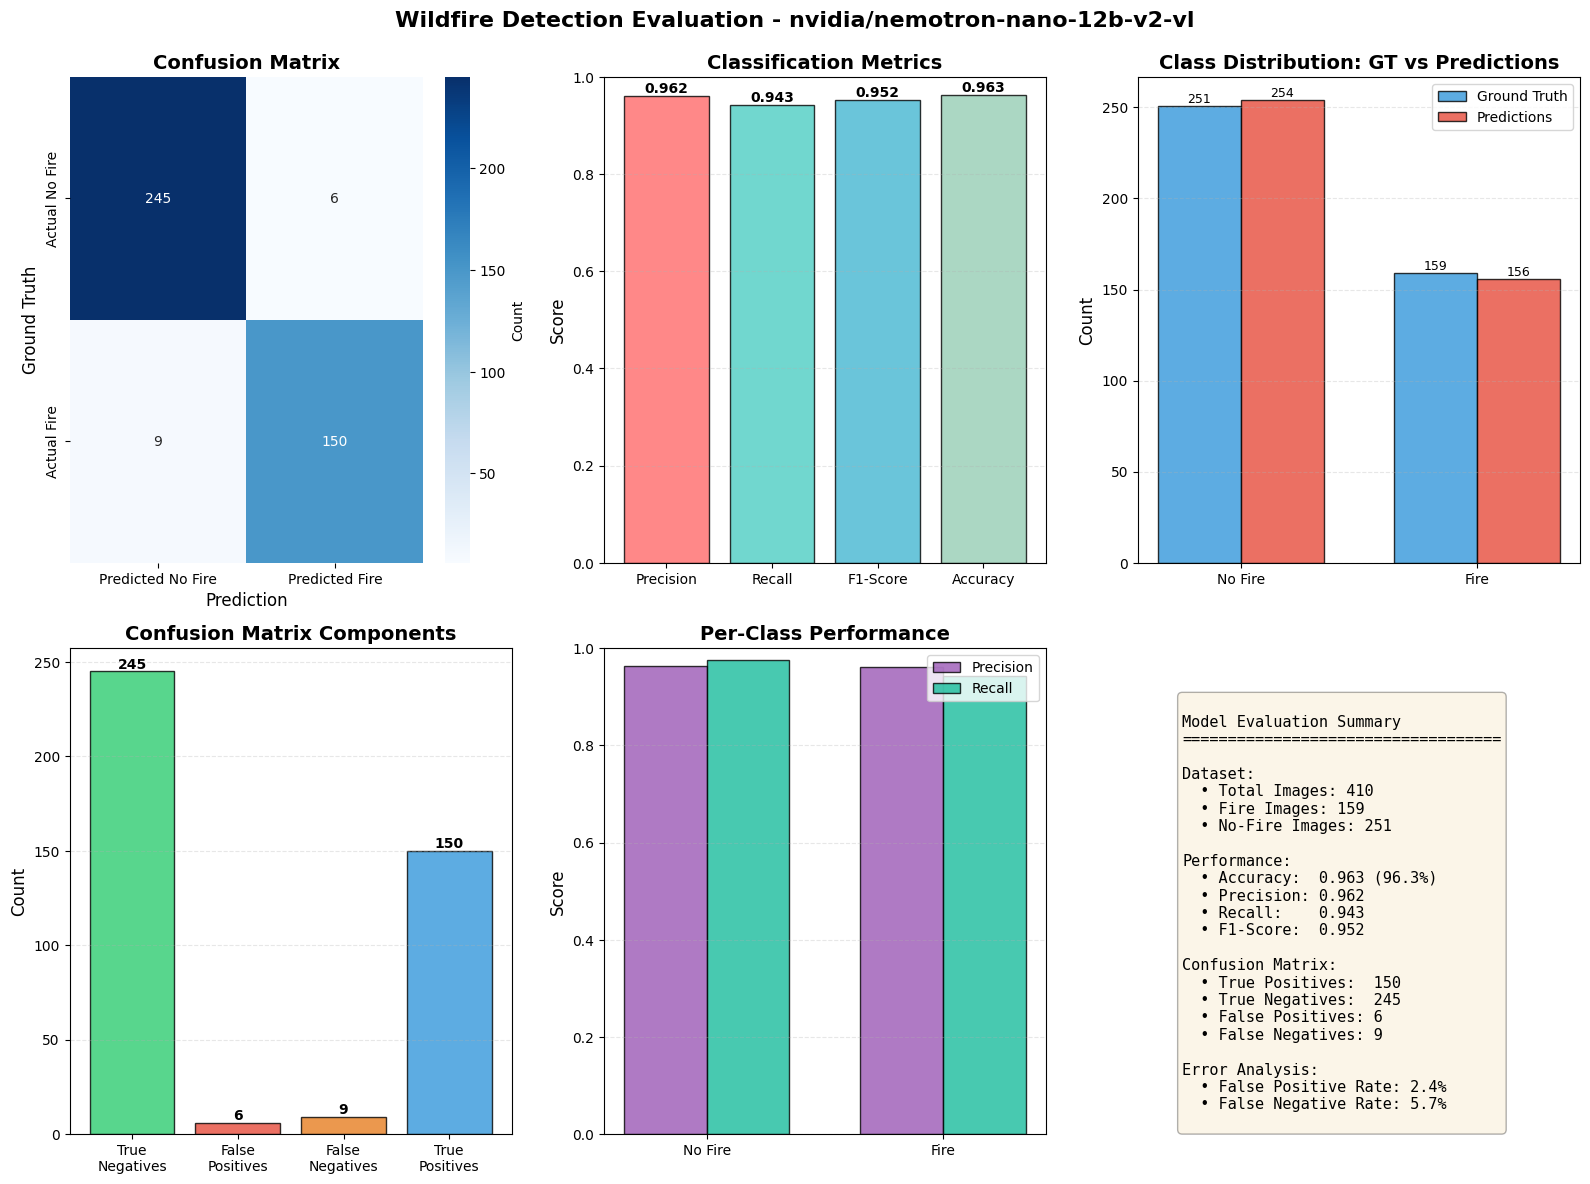

In [48]:
# Set up the plot style
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with multiple subplots
fig = plt.figure(figsize=(16, 12))

# 1. Confusion Matrix Heatmap
ax1 = plt.subplot(2, 3, 1)
cm = np.array([[TN, FP], [FN, TP]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Fire', 'Predicted Fire'],
            yticklabels=['Actual No Fire', 'Actual Fire'],
            cbar_kws={'label': 'Count'}, ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('Ground Truth', fontsize=12)
ax1.set_xlabel('Prediction', fontsize=12)

# 2. Classification Metrics Bar Chart
ax2 = plt.subplot(2, 3, 2)
metrics_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
metrics_values = [precision, recall, f1, accuracy]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = ax2.bar(metrics_names, metrics_values, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylim([0, 1.0])
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Classification Metrics', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Ground Truth vs Predictions Distribution
ax3 = plt.subplot(2, 3, 3)
x_pos = np.arange(2)
gt_counts = [len(nofire_images), len(fire_images)]
pred_counts = [int((y_pred == 0).sum()), int((y_pred == 1).sum())]
width = 0.35
bars1 = ax3.bar(x_pos - width/2, gt_counts, width, label='Ground Truth', 
                color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x_pos + width/2, pred_counts, width, label='Predictions', 
                color='#e74c3c', alpha=0.8, edgecolor='black')
ax3.set_ylabel('Count', fontsize=12)
ax3.set_title('Class Distribution: GT vs Predictions', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['No Fire', 'Fire'])
ax3.legend()
ax3.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9)

# 4. Confusion Matrix Components Breakdown
ax4 = plt.subplot(2, 3, 4)
cm_labels = ['True\nNegatives', 'False\nPositives', 'False\nNegatives', 'True\nPositives']
cm_values = [TN, FP, FN, TP]
cm_colors = ['#2ecc71', '#e74c3c', '#e67e22', '#3498db']
bars = ax4.bar(cm_labels, cm_values, color=cm_colors, alpha=0.8, edgecolor='black')
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Confusion Matrix Components', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3, linestyle='--')
for bar, value in zip(bars, cm_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(value)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. Per-Class Performance
ax5 = plt.subplot(2, 3, 5)
# Calculate per-class metrics
fire_precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
fire_recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
nofire_precision = TN / (TN + FN) if (TN + FN) > 0 else 0.0
nofire_recall = TN / (TN + FP) if (TN + FP) > 0 else 0.0

x = np.arange(2)
width = 0.35
prec_bars = ax5.bar(x - width/2, [nofire_precision, fire_precision], width, 
                    label='Precision', color='#9b59b6', alpha=0.8, edgecolor='black')
rec_bars = ax5.bar(x + width/2, [nofire_recall, fire_recall], width, 
                   label='Recall', color='#1abc9c', alpha=0.8, edgecolor='black')
ax5.set_ylabel('Score', fontsize=12)
ax5.set_title('Per-Class Performance', fontsize=14, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(['No Fire', 'Fire'])
ax5.set_ylim([0, 1.0])
ax5.legend()
ax5.grid(axis='y', alpha=0.3, linestyle='--')

# 6. Summary Statistics
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
summary_text = f"""
Model Evaluation Summary
{'='*35}

Dataset:
  • Total Images: {len(y_true)}
  • Fire Images: {len(fire_images)}
  • No-Fire Images: {len(nofire_images)}

Performance:
  • Accuracy:  {accuracy:.3f} ({accuracy*100:.1f}%)
  • Precision: {precision:.3f}
  • Recall:    {recall:.3f}
  • F1-Score:  {f1:.3f}

Confusion Matrix:
  • True Positives:  {TP}
  • True Negatives:  {TN}
  • False Positives: {FP}
  • False Negatives: {FN}

Error Analysis:
  • False Positive Rate: {FP/(FP+TN)*100:.1f}%
  • False Negative Rate: {FN/(FN+TP)*100:.1f}%
"""
ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes,
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle(f'Wildfire Detection Evaluation - {MODEL_NAME}', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

# Save the figure
viz_path = OUTPUT_CSV.parent / "evaluation_visualizations.png"
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"✓ Visualizations saved to: {viz_path}")

plt.show()


## 11. Save Metrics Summary


In [49]:
metrics_summary = {
    "model": MODEL_NAME,
    "test_set_size": len(y_true),
    "fire_images": len(fire_images),
    "nofire_images": len(nofire_images),
    "confusion_matrix": {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN,
    },
    "metrics": {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
    },
}

# Save metrics to JSON
metrics_json_path = OUTPUT_CSV.parent / "metrics_summary.json"
with open(metrics_json_path, "w") as f:
    json.dump(metrics_summary, f, indent=2)

print(f"✓ Metrics summary saved to: {metrics_json_path}")
print(f"\nMetrics Summary:")
print(json.dumps(metrics_summary, indent=2))


✓ Metrics summary saved to: /raid/aasthaj/wildfire-nemo/outputs/metrics_summary.json

Metrics Summary:
{
  "model": "nvidia/nemotron-nano-12b-v2-vl",
  "test_set_size": 410,
  "fire_images": 159,
  "nofire_images": 251,
  "confusion_matrix": {
    "TP": 150,
    "FP": 6,
    "FN": 9,
    "TN": 245
  },
  "metrics": {
    "precision": 0.9615384615384616,
    "recall": 0.9433962264150944,
    "f1_score": 0.9523809523809524,
    "accuracy": 0.9634146341463414
  }
}
